In [ ]:
pip install -q transformers datasets tokenizers

     |████████████████████████████████| 1.3MB 12.5MB/s 
     |████████████████████████████████| 153kB 49.9MB/s 
     |████████████████████████████████| 2.9MB 55.6MB/s 
     |████████████████████████████████| 1.1MB 52.3MB/s 
     |████████████████████████████████| 890kB 39.5MB/s 
     |████████████████████████████████| 245kB 49.8MB/s 
     |████████████████████████████████| 17.7MB 207kB/s 
ERROR: transformers 3.5.1 has requirement tokenizers==0.9.3, but you'll have tokenizers 0.9.4 which is incompatible.


# Домашнее задание. Transformers.

Привет! Это очередное домашнее задание, но теперь ты познакомишься с моделя трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import torch
import torch.nn as nn

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config
from datasets import load_dataset

In [ ]:
device = "cuda" if torch.cuda.is_available else "cpu"

Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего. 

In [ ]:
emotion_dataset = load_dataset("emotion")

Using custom data configuration default


Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/5276a3f9a2c014ee528f5cca7ad34f185b886acd0f60fe18c61c6768662ca828. Subsequent calls will reuse this data.


Посмотри, из чего состоит `emotion_dataset`:

In [ ]:
emotion_dataset

DatasetDict({'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000), 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000), 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)})

In [ ]:
emotion_dataset["train"]

Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000)

In [ ]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [ ]:
emotion_dataset["train"]["label"][0]

'sadness'

In [ ]:
len(emotion_dataset["train"])

16000

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [ ]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

Подготовь класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотри, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумай, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [ ]:
tokenizer.tokenize(emotion_dataset["train"]["text"][0])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

In [ ]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [ ]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [ ]:
# Если надо, попрактикуйся работать с токенайзером здесь

In [ ]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.dataset[self.part]['text'][idx]
        label = self.dataset[self.part]['label'][idx]
        
        tokenizer_output = self.tokenizer.encode_plus(text,max_length=128, padding="max_length",return_tensors="pt")
        target = self.label2num[label]
        return {
            "input_ids": tokenizer_output["input_ids"], 
            "mask": tokenizer_output['attention_mask'],
            "target": target
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [ ]:
train_dataset = TweetDataset("train")
valid_dataset = TweetDataset("validation") # validation
test_dataset = TweetDataset("test")

In [ ]:
batch_size = 64 # Задай batch_size

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,batch_size = batch_size
)
valid_loader = torch.utils.data.DataLoader(
    dataset=valid_dataset,batch_size = batch_size
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,batch_size = batch_size
)

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [ ]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=8
)
model_0 = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста

Подготовь оптимайзер и критерий:

In [ ]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_0.parameters(),lr=lr)
criterion = nn.CrossEntropyLoss()
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Посмотри, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

In [ ]:
tokens = train_dataset[0]['input_ids'].to(device)  # Получи токены из датасета
mask = train_dataset[0]['mask'].to(device) # Получи маску из датасета

model_0(tokens,attention_mask=mask) # Посмотри на аутпут

(tensor([[-0.2527,  0.7387,  0.1271, -0.2736, -0.1409, -0.1262, -0.3396, -0.6285]],
        device='cuda:0', grad_fn=<IndexBackward>),
 (tensor([[[[[-7.0784e-01, -5.4579e-01, -2.8320e-01,  ...,  2.1482e-01,
              -6.9495e-01, -8.5258e-01],
             [-1.2359e+00, -3.1283e-02, -2.5918e-02,  ..., -1.2905e-01,
               1.2093e+00, -1.4048e-01],
             [-5.6840e-02,  4.4870e-01,  3.9635e-01,  ..., -5.5985e-01,
               6.1149e-01,  2.3744e-01],
             ...,
             [ 7.6633e-01, -8.9898e-01, -3.2389e-01,  ...,  9.8414e-01,
              -6.1998e-01,  2.2431e-01],
             [ 7.9073e-01, -3.1823e-01, -7.8111e-02,  ...,  5.0988e-01,
               3.3193e-01, -2.9448e-01],
             [ 1.3600e-01,  3.6985e-02, -6.3537e-01,  ..., -8.4156e-03,
              -6.7725e-01, -3.8128e-02]],
  
            [[ 9.3233e-01,  2.8179e-01,  9.2940e-01,  ...,  3.9798e-01,
              -2.5120e-01, -3.1071e-01],
             [ 9.7617e-02, -9.0563e-01, -3.3298e-01,

Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

In [ ]:
from tqdm.notebook import tqdm


def acc_count(tensor,target):
    sm = torch.softmax(tensor,dim=1)
    win = sm.argmax(dim=1)
    cor = (win == target)
    accuracy = cor.sum().float() / float( target.size(0) )
    return accuracy

num_epochs = 10

# Train loop
for e in range(num_epochs):
    model_0.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        target = batch['target'].to(device)
        input_ids = batch['input_ids'].squeeze(1).to(device)
        mask  = batch['mask'].squeeze(1).to(device)
        optimizer.zero_grad()
        preds = model_0(input_ids=input_ids,attention_mask=mask,labels=target)
        train_loss += criterion(preds[1],target)
        loss = criterion(preds[1],target)
        loss.backward()
        optimizer.step()
        
    valid_loss = 0
    valid_acc = 0
    model_0.eval()
    with torch.no_grad():
        for batch in valid_loader:
            target = batch['target'].to(device)
            input_ids = batch['input_ids'].squeeze(1).to(device)
            mask  = batch['mask'].squeeze(1).to(device)
            preds = model_0(input_ids=input_ids,attention_mask=mask,labels=target)
            valid_loss += criterion(preds[1], target)
            valid_acc += acc_count(preds[1],target).item()
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
        
# Testing
test_acc = 0
model_0.eval()
with torch.no_grad():
    for batch in test_loader:
        target = batch['target'].to(device)
        input_ids = batch['input_ids'].squeeze(1).to(device)
        mask  = batch['mask'].squeeze(1).to(device)
        preds = model_0(input_ids=input_ids,attention_mask=mask,labels=target)
        test_acc += acc_count(preds[1],target).item()
print(f"Test Acc: {test_acc / len(test_loader)}")


Train Loss: 1.3227027654647827,Valid Loss: 1.0877193212509155,Valid Acc: 0.58642578125



Train Loss: 0.9505957961082458,Valid Loss: 0.8261232376098633,Valid Acc: 0.6982421875



Train Loss: 0.6738045811653137,Valid Loss: 0.6868724822998047,Valid Acc: 0.75634765625



Train Loss: 0.49429985880851746,Valid Loss: 0.6505313515663147,Valid Acc: 0.77294921875



Train Loss: 0.3740057051181793,Valid Loss: 0.5961583256721497,Valid Acc: 0.79833984375



Train Loss: 0.2881713807582855,Valid Loss: 0.5931446552276611,Valid Acc: 0.8095703125



Train Loss: 0.23638655245304108,Valid Loss: 0.5669265389442444,Valid Acc: 0.8212890625



Train Loss: 0.18650288879871368,Valid Loss: 0.5497090816497803,Valid Acc: 0.83251953125



Train Loss: 0.16390980780124664,Valid Loss: 0.5226917862892151,Valid Acc: 0.84423828125



Train Loss: 0.12938597798347473,Valid Loss: 0.5404444932937622,Valid Acc: 0.845703125
Test Acc: 0.85302734375


После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [ ]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return np.array(attn)

In [ ]:
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
text = emotion_dataset['train']['text'][5] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

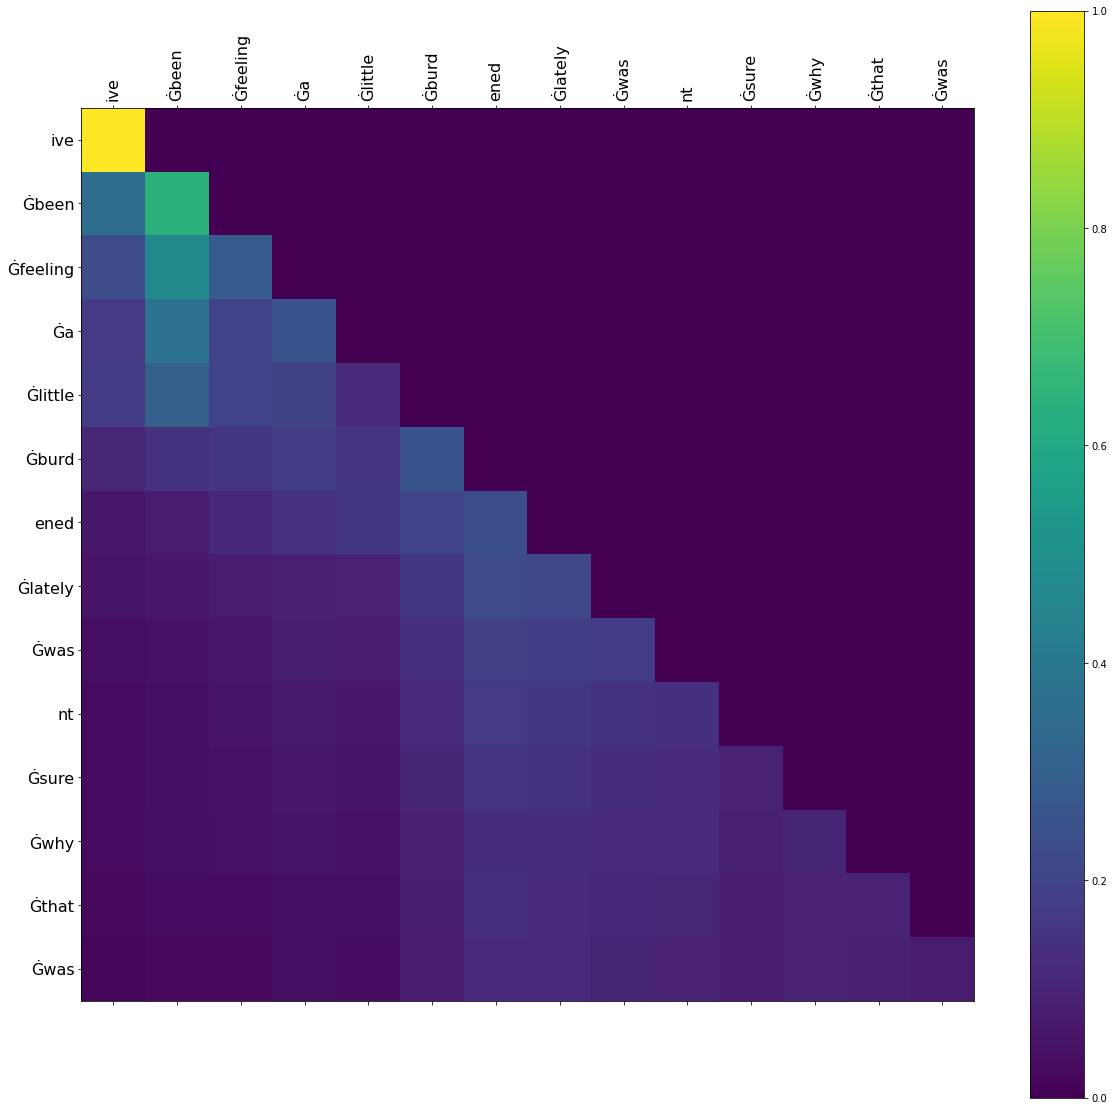

In [ ]:
attns = get_attention_matrixes(model_0, tokenizer, text)
show_attention(tokens, attns[-1][0])

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [ ]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=8
).to(device)

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_1.parameters(),lr=lr)
criterion = nn.CrossEntropyLoss()
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [ ]:
from tqdm.notebook import tqdm


num_epochs = 10

# Train loop
for e in range(num_epochs):
    model_1.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        target = batch['target'].to(device)
        input_ids = batch['input_ids'].squeeze(1).to(device)
        mask  = batch['mask'].squeeze(1).to(device)
        optimizer.zero_grad()
        preds = model_1(input_ids=input_ids,attention_mask=mask,labels=target)
        train_loss += criterion(preds[1],target)
        loss = criterion(preds[1],target)
        loss.backward()
        optimizer.step()
        
    valid_loss = 0
    valid_acc = 0
    model_1.eval()
    with torch.no_grad():
        for batch in valid_loader:
            target = batch['target'].to(device)
            input_ids = batch['input_ids'].squeeze(1).to(device)
            mask  = batch['mask'].squeeze(1).to(device)
            preds = model_1(input_ids=input_ids,attention_mask=mask,labels=target)
            valid_loss += criterion(preds[1], target)
            valid_acc += acc_count(preds[1],target).item()
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
        
# Testing
test_acc = 0
model_1.eval()
with torch.no_grad():
    for batch in test_loader:
        target = batch['target'].to(device)
        input_ids = batch['input_ids'].squeeze(1).to(device)
        mask  = batch['mask'].squeeze(1).to(device)
        preds = model_1(input_ids=input_ids,attention_mask=mask,labels=target)
        test_acc += acc_count(preds[1],target).item()
print(f"Test Acc: {test_acc / len(test_loader)}")


Train Loss: 1.5683250427246094,Valid Loss: 0.9399625062942505,Valid Acc: 0.67236328125



Train Loss: 0.6717451214790344,Valid Loss: 0.4271184504032135,Valid Acc: 0.86083984375



Train Loss: 0.35646170377731323,Valid Loss: 0.29057756066322327,Valid Acc: 0.9033203125



Train Loss: 0.25280243158340454,Valid Loss: 0.2219136506319046,Valid Acc: 0.91650390625



Train Loss: 0.20655584335327148,Valid Loss: 0.20013427734375,Valid Acc: 0.9189453125



Train Loss: 0.17449527978897095,Valid Loss: 0.1870601922273636,Valid Acc: 0.92138671875



Train Loss: 0.1539396047592163,Valid Loss: 0.1708962470293045,Valid Acc: 0.92041015625



Train Loss: 0.1386694312095642,Valid Loss: 0.16201908886432648,Valid Acc: 0.93115234375



Train Loss: 0.12883153557777405,Valid Loss: 0.15720488131046295,Valid Acc: 0.92724609375



Train Loss: 0.12473475188016891,Valid Loss: 0.15698841214179993,Valid Acc: 0.92529296875
Test Acc: 0.9248046875


Есть ли прирост качества или скорости обучения?

Посмотри на карты внимания. Есть ли отличие от предыдущего случая?

In [ ]:
text = emotion_dataset['train']['text'][5] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

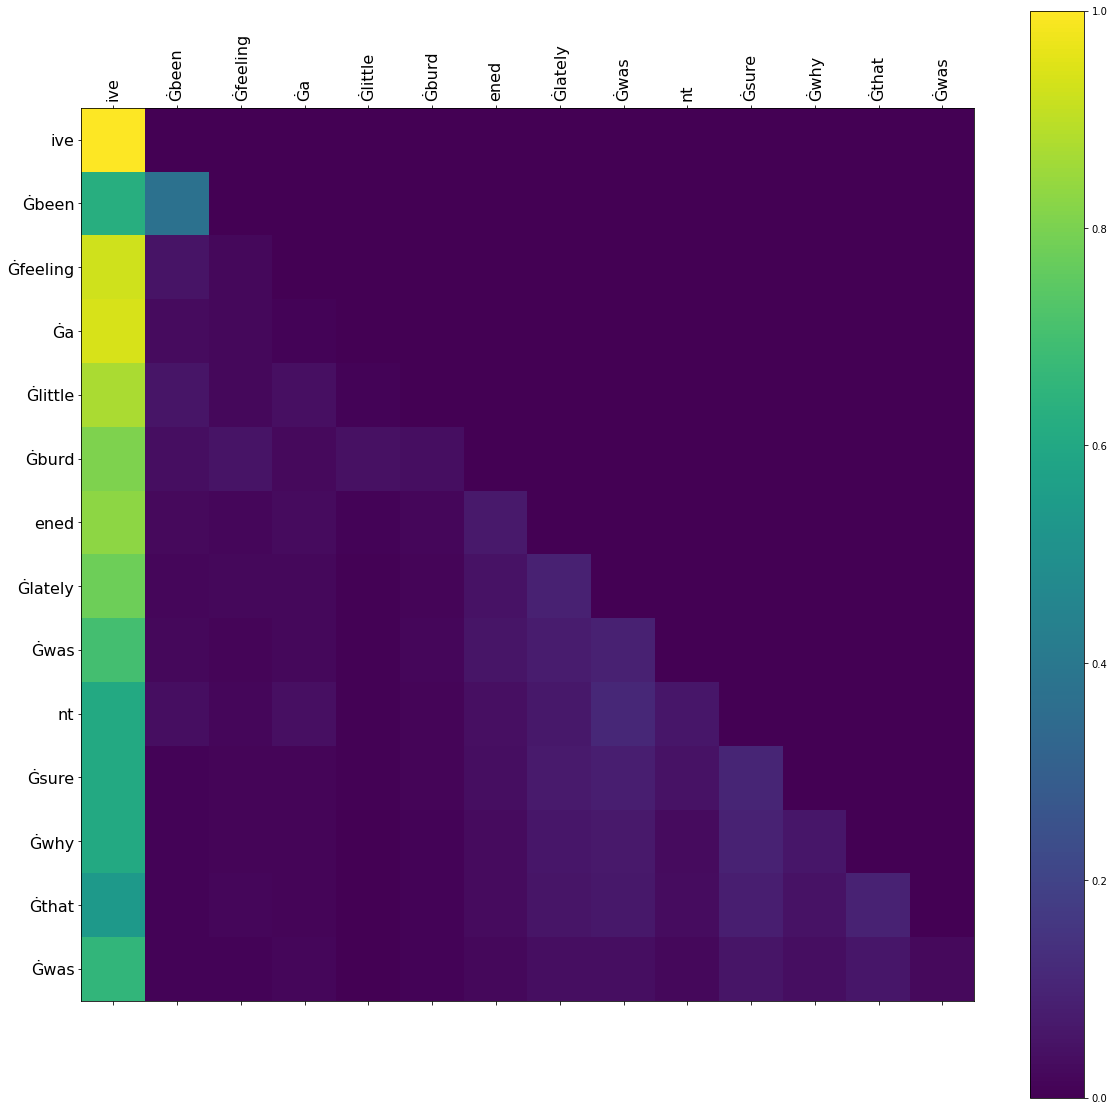

In [ ]:
attns = get_attention_matrixes(model_1, tokenizer, text)
show_attention(tokens, attns[-1][0])

## Отчет

Покажи здесь, что ты выполнил по этой работе. Ответь на несколько вопросов:
- Какой подход оказался лучше? 
- На какие слова модель большего всего обращала внимание?
- На каких слоях/головах модель обращала внимание?


Fine-tuning показал большую точность и более быструю обучаемость.
И больше смотрит на контекст.
